In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [3]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
epochs = 1
batch_size = 100
learning_rate = 0.001

# image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root = "./data",
                                            train = True,
                                            transform = transform,
                                            download = True)

test_dataset = torchvision.datasets.CIFAR10(root = "./data",
                                            train = False,
                                            transform = transform)

# data loader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)


Files already downloaded and verified


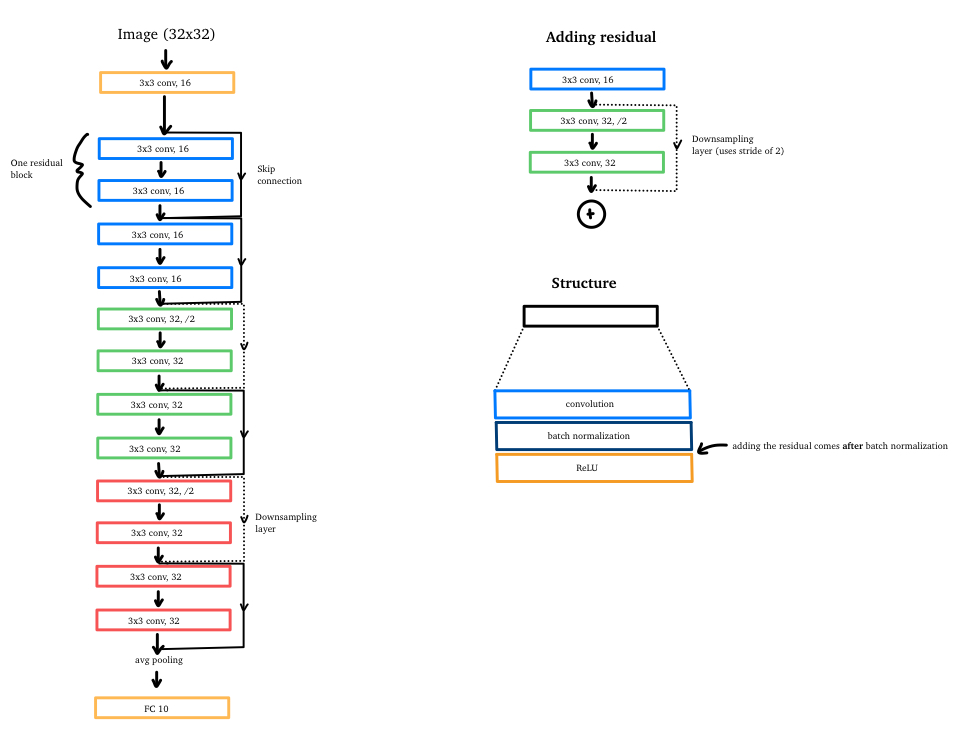

In [4]:
def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride) # need to downsample
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True) # makes ReLU an inplace operation
        self.conv2 = conv3x3(out_channels, out_channels) # no need to downsample second convolutional layer; after the first layer changes the dimensions, both the in and out channels are the same
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x.clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:    
            residual = self.downsample(x)  # downsample if neccessary
        out += residual
        out = self.relu(out)
        return out
            
       

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        """
        layers will be a list: [2,2,2]
        size = number of layers
        elements in the list are number of residual blocks in each layer
        
        """
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16) # input is an rgb image with 3 channels, will be processed through 16 feature maps, so output is 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8) # average pool with kernel size 8 (size of feature map = size of kernel -> avg all the values in feature map)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None 
        if (stride != 1) or (self.in_channels != out_channels): # downsample needed if stride is not 1 or if in/out channels don't match
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride = stride),
                                        nn.BatchNorm2d(out_channels))
        residual_blocks = []
        residual_blocks.append(block(self.in_channels, out_channels, stride, downsample)) # first residual block in layer 
        self.in_channels = out_channels # makes sure that the in/out channels match as we change them in different residual layers
        for i in range(1, blocks):
            residual_blocks.append(block(out_channels, out_channels)) # adds the rest of the residual blocks to the layer (no need for downsampling after the first block)
                
        return nn.Sequential(*residual_blocks)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
        
        

In [6]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [7]:
decay = 0
model.train()
for epoch in range(epochs):
    
    # Decay the learning rate every 20 epochs
    if (epoch+1) % 20 == 0:
        decay+=1
        optimizer.param_groups[0]['lr'] = learning_rate * (0.5**decay)
        print("The new learning rate is {}".format(optimizer.param_groups[0]['lr']))
        
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f"Epoch [{epoch+1}/{epochs}], Step [{i + 1}/{len(train_loader)}] Loss: {loss.item():.4f}")

Epoch [1/1], Step [100/500] Loss: 1.5130
Epoch [1/1], Step [200/500] Loss: 1.4585
Epoch [1/1], Step [300/500] Loss: 1.2837
Epoch [1/1], Step [400/500] Loss: 1.2462
Epoch [1/1], Step [500/500] Loss: 1.1664


In [8]:
# test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the test images: {(100 * correct / total)} %")

Accuracy of the model on the test images: 45.87 %


In [9]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [10]:
# class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# predict function
def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    class_index = predicted.item()
    print(f'Predicted class: {classes[class_index]}')


In [11]:
# example test

model.eval()
predict("dog.jpeg")

Predicted class: dog
